### Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth **MSA**).

**MSA** methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)

We will use the files of FASTA format (*curated_uniprot.fasta_*) with the information of hsp regions and the amino acid sequences.

In [186]:
import argparse
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import stats
from os import path
import sys
import json
import os
import subprocess
from Bio.Blast import NCBIXML
import ipywidgets as widgets

In [3]:
# Check the current directory for assigning the variable for the functions below
print('Get current working directory:', os.getcwd())

Get current working directory: /Users/alina/HMMER


In [4]:
directory = "/Users/alina/HMMER"

#### Creating a dataframe

Here, we have defined a function that can parse a fasta file into a pandas dataframe. This function can be used to add any additional column containing information about hsp.

In [170]:
# Parse the fasta file to create a pandas dataframe
input_files = ['{}/curated_uniprot.fasta_75'.format(directory)]
dfs = []
max_query_length = 0

for input_file in input_files:
    with open(input_file) as f:
        blast_records = NCBIXML.parse(f)
        data = []

        # Iterate PSIBLAST rounds
        for blast_record in blast_records:
            query_id = blast_record.query

            # Get the length of the query sequence
            query_length = int(blast_record.query_letters)
            if query_length > max_query_length:
                max_query_length = query_length

            # Iterate alignments (here just one)
            for i, alignment in enumerate(blast_record.alignments):
                subject_id = alignment.title

                # Iterate pairwise alignments
                for hsp in alignment.hsps:
                    data.append((query_id.split(" ")[0], # it's not necessary to print the whole id
                                    subject_id.split(" ")[0], # the same as above
                                    query_length,
                                    hsp.align_length,
                                    hsp.query,
                                    hsp.match,
                                    hsp.sbjct,
                                    hsp.query_start,
                                    hsp.query_end,
                                    hsp.sbjct_start,
                                    hsp.sbjct_end,
                                    hsp.identities,
                                    hsp.positives,
                                    hsp.gaps,
                                    hsp.expect,
                                    hsp.score,
                                    ))

                    # Skip duplicated subjects
                    break

        dfs.append(pd.DataFrame(data, columns=["query_id", "subject_id", "query_len", "hsp_len", "query_seq",
                                               "match_seq", "subject_seq", "query_start", "query_end",
                                               "subject_start", "subject_end", "identity", "positive",
                                               "gaps", "eval", "bit_score"]))

In [171]:
# Print the resulting dataframe
df = dfs[0]
df.head()

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0


#### Counts of subject sequences for query id

Then we calculate the number of counts of the subject sequences for each query id. We need to pay attention on each query id and summarize the data for all subject sequences occurred for that query, not the individual pair 'query-sequence'.

In [172]:
# Calculate the counts of subject sequences for the query id
grouped = df.groupby('query_id')['subject_seq'].nunique().reset_index(name='count')

# Expand the df with a 'count' column
df = pd.merge(df, grouped, on='query_id')
df.head()

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,146
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,146
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,146
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,146
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,146


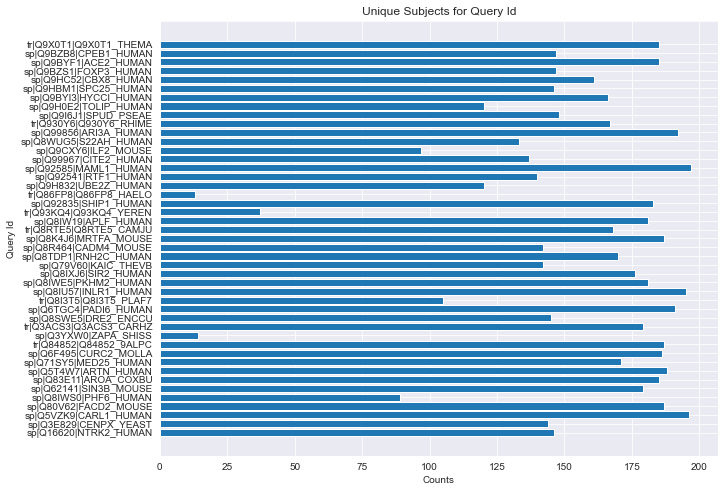

In [245]:
# Count counts of subject sequences for each query id
figure(figsize=(10, 8))
plt.barh(df['query_id'], df['count'])
plt.xlabel('Counts')
plt.ylabel('Query Id')
plt.title('Unique Subjects for Query Id')
plt.show()

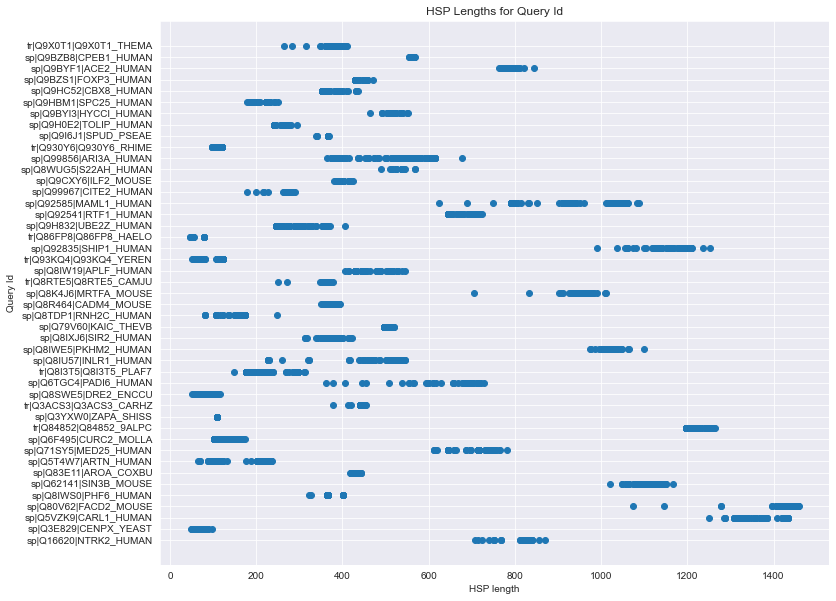

In [251]:
# Count hsp length for each query id
figure(figsize=(12, 10))
plt.scatter(df['hsp_len'], df['query_id'])
plt.xlabel('HSP length')
plt.ylabel('Query Id')
plt.title('HSP Lengths for Query Id')
plt.show()

This plot displays the distribution of hsp length over query ids.

#### Query id analysis

Before we showed the overall proportion of unique subjects for query ids, but now we want to perform an analysis of each id separately.
We start with creating a dropdown list for query ids.

In [263]:
# Create a dropdown list of query ids (more than 1 can be chosen)
output = widgets.SelectMultiple(
    options=df["query_id"].unique(),
    rows=10,
    description='Query id',
    layout={'width': 'max-content'},
    disabled=False
)
display(output)

SelectMultiple(description='Query id', layout=Layout(width='max-content'), options=('sp|Q16620|NTRK2_HUMAN', '…

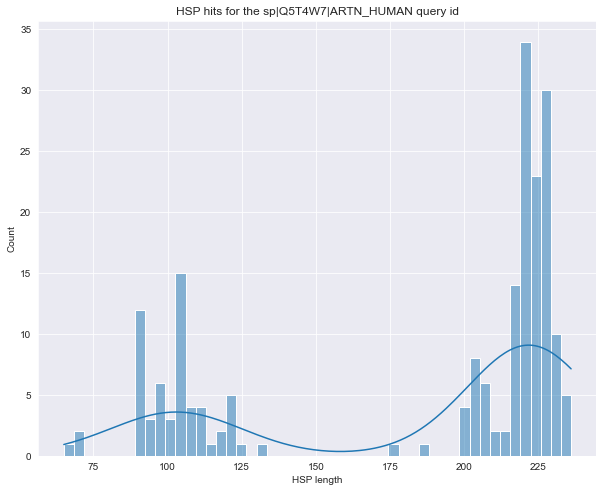

In [271]:
# Select query_id (1 or more) and filter df using these values
selected_id = output.value
selected = df[df["query_id"].isin(selected_id)]

# Create a bar plot for the hits for the selected query sequence
figure(figsize=(10, 8))
sns.histplot(selected['hsp_len'], kde=True, bins=50)
plt.xlabel('HSP length')
plt.ylabel('Count')
plt.title(f'HSP hits for the {", ".join(selected_id)} query id')
plt.show()

This plot shows how many times a particular HSP length is represented in chosen query id.

In [276]:
# Generate the MSA

out_files = ["{}/output.fasta".format(directory)]

for df, out_file in zip(dfs, out_files):
    with open(out_file, "w") as fout:
        for index, row in df.iterrows():
            mapped_seq = ["-"] * max_query_length # Empty list of length = maximum query length
            c = 0
            if row["eval"] < 0.01:
                with open(out_file, "a") as fout: # append the output.fasta
                    for l_q, l_s in zip(row["query_seq"], row["subject_seq"]):
                        if l_q != " " and l_q != "-": # the element in query sequence
                            # avoid 'IndexError: list assignment index out of range'
                            if 1 <= row["query_start"] + c <= max_query_length:
                                mapped_seq[row["query_start"] + c - 1] = l_s if l_s != " " else "-"
                            c += 1
                    fout.write(">{}\n{}\n".format(row["subject_id"], "".join(mapped_seq)))

In [275]:
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# find the length of the longest sequence in the dataframe
max_length = max(len(s) for s in df['query_seq'])

# create a list of SeqRecord objects from the sequences in your dataframe
seq_records = []
for row in df.itertuples():
    query_seq = Seq(str(row.query_seq).ljust(max_length, "-"))
    sbjct_seq = Seq(str(row.subject_seq).ljust(max_length, "-"))
    match_seq = Seq(str(row.match_seq).replace(" ", "-").ljust(max_length, "-"))  # replace spaces with gaps
    aligned_seq = query_seq + match_seq + sbjct_seq
    seq_record = SeqRecord(aligned_seq, id=row.query_id.split(" ")[0])
    seq_records.append(seq_record)

# create a MultipleSeqAlignment object from the SeqRecord objects
msa = MultipleSeqAlignment(seq_records)

# print the alignment
print(msa.format("fasta"))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

